# Apprentissage supervisé - Régression

Autre grande catégorie de l'apprentissage supervisé : la régression. Le principe est très simple, on chercher à trouver la courbe optimale permettant de prévoir la valeur de sortie à partie d'une ou plusieurs valeurs d'entrées. Il existe plusieurs algorithmes de régressions, mais celui qui va nous intéresser concerne la "régression linéaire", elle est de deux types :
- Une valeur d'entrée -> Régression linéaire simple
- Plusieurs valeurs d'entrée -> Régression linéaire multiple (la plus courante)

![Image regression](../_images/regression.jpg)

### But du TP
- Découvrir la régression linéaire simple
- Tester différents modèles de régression linéaire

## Régression linéaire simple

La plus simple à utiliser mais la moins courante, la régression linéaire simple consiste à trouver la droite correspondant à l'équation suivante :
$$ y = ax + b $$
A partir de notre jeu de données qui ressemble à quelque chose comme ceci
![Image regression](../_images/dataframe-linear.jpg)

Nous allons utiliser un autre classique du Machine Learning : logements.csv, c'est un dataset qui contient une surface et le loyer, notre but va donc être de trouver la courbe optimale permettant de prévoir la surface en fonction d'un loyer (on peut aussi choisir de faire l'inverse). Encore une fois, numpy, matplotlib.pyplot, pandas et scikit-learn vont être de précieux atouts (voir les précédentes pratiques si vous avez oublié ce que font ces outils).

# Avant-propos - Pour les utilisateurs de Google colab

Petit apparté pour les utilisateurs de google colab. Pour utiliser la méthode `pd.read_csv()`, il faudra rajouter quelques lignes de codes supplémentaires pour pouvoir charger un fichier, les voici.

```python
# Première cellule jupyter
from google.colab import files
uploaded = files.upload()
```

```python
# Seconde cellule jupyter
import io
# Très important : le nom du fichier passé en paramètre de la fonction "uploaded" doit avoir le même nom que le fichier que vous avez uploadé
df = pd.read_csv(io.BytesIO(uploaded['nom-du-fichier-uploader.csv']))
```

- [Voir plus  d'informations sur le chargement de fichiers externes avec Google colab](https://towardsdatascience.com/3-ways-to-load-csv-files-into-colab-7c14fcbdcb92)

# Phase 1 : Chargement des données

In [3]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

logements_df_src = pd.read_csv("datasets/slr-logements.csv")
logements_df = logements_df_src.copy()

On remarque donc que notre jeu de données est composé de deux colonnes "loyer" et "surface". Notre régression étant linéaire, nous en concluons que "loyer" est la valeur d'entrée et "surface", celle de sortie. Notre équation sera donc de la forme suivante :
$$ surface = a(loyer) + b $$
scikit-learn va nous aider à trouver les valeurs de "a" et "b". Mais avant, phase 2 : exploration des données

# Phase 2 : Exploration des données

Notre dataset étant relativement simple, on va avant tout chercher ces choses principalement :
- S'il y a des valeurs manquantes. `df.isnull().sum()`
- Le format des données. `df.dtypes`
- Les valeurs min/max. `df.describe()`
- S'il y a des données aberrantes dans nos valeurs d'entrées. `df["nom_de_la_colonne"].std()`

### Les données aberrantes (outliers en anglais)
Dans un jeu de données où les valeurs numériques ont une très grande importance, il faut faire très attention aux données aberrantes, une donnée aberrante est une donnée qui pourrait potentiellement fausser notre modèle d'apprentissage notamment pour les regressions, algorithmes où les variables sont quantitatives (des nombres). Pour savoir s'il y a des valeurs aberrantes deux choix s'offrent à nous :
- Calculer l'écart-type, soit l'écart entre deux valeurs, plus il est grand, plus les valeurs sont disparates
- Afficher un graphique type nuage de points

Quelque soit la méthode il est important de vérifier la présence de ces données, à défaut de les supprimer / remplacer. Notez qu'il existe des modèles qui permettent d'être plus ou moins tolérant aux données aberrantes, c'est le cas du HuberRegressor. Mais ce n'est pas forcément la meilleure des méthodes.
- [Voir documentation de HuberRegressor](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.HuberRegressor.html)

## A vous de coder

'Ecart type de notre colonne loyer : 2201.364353113282'

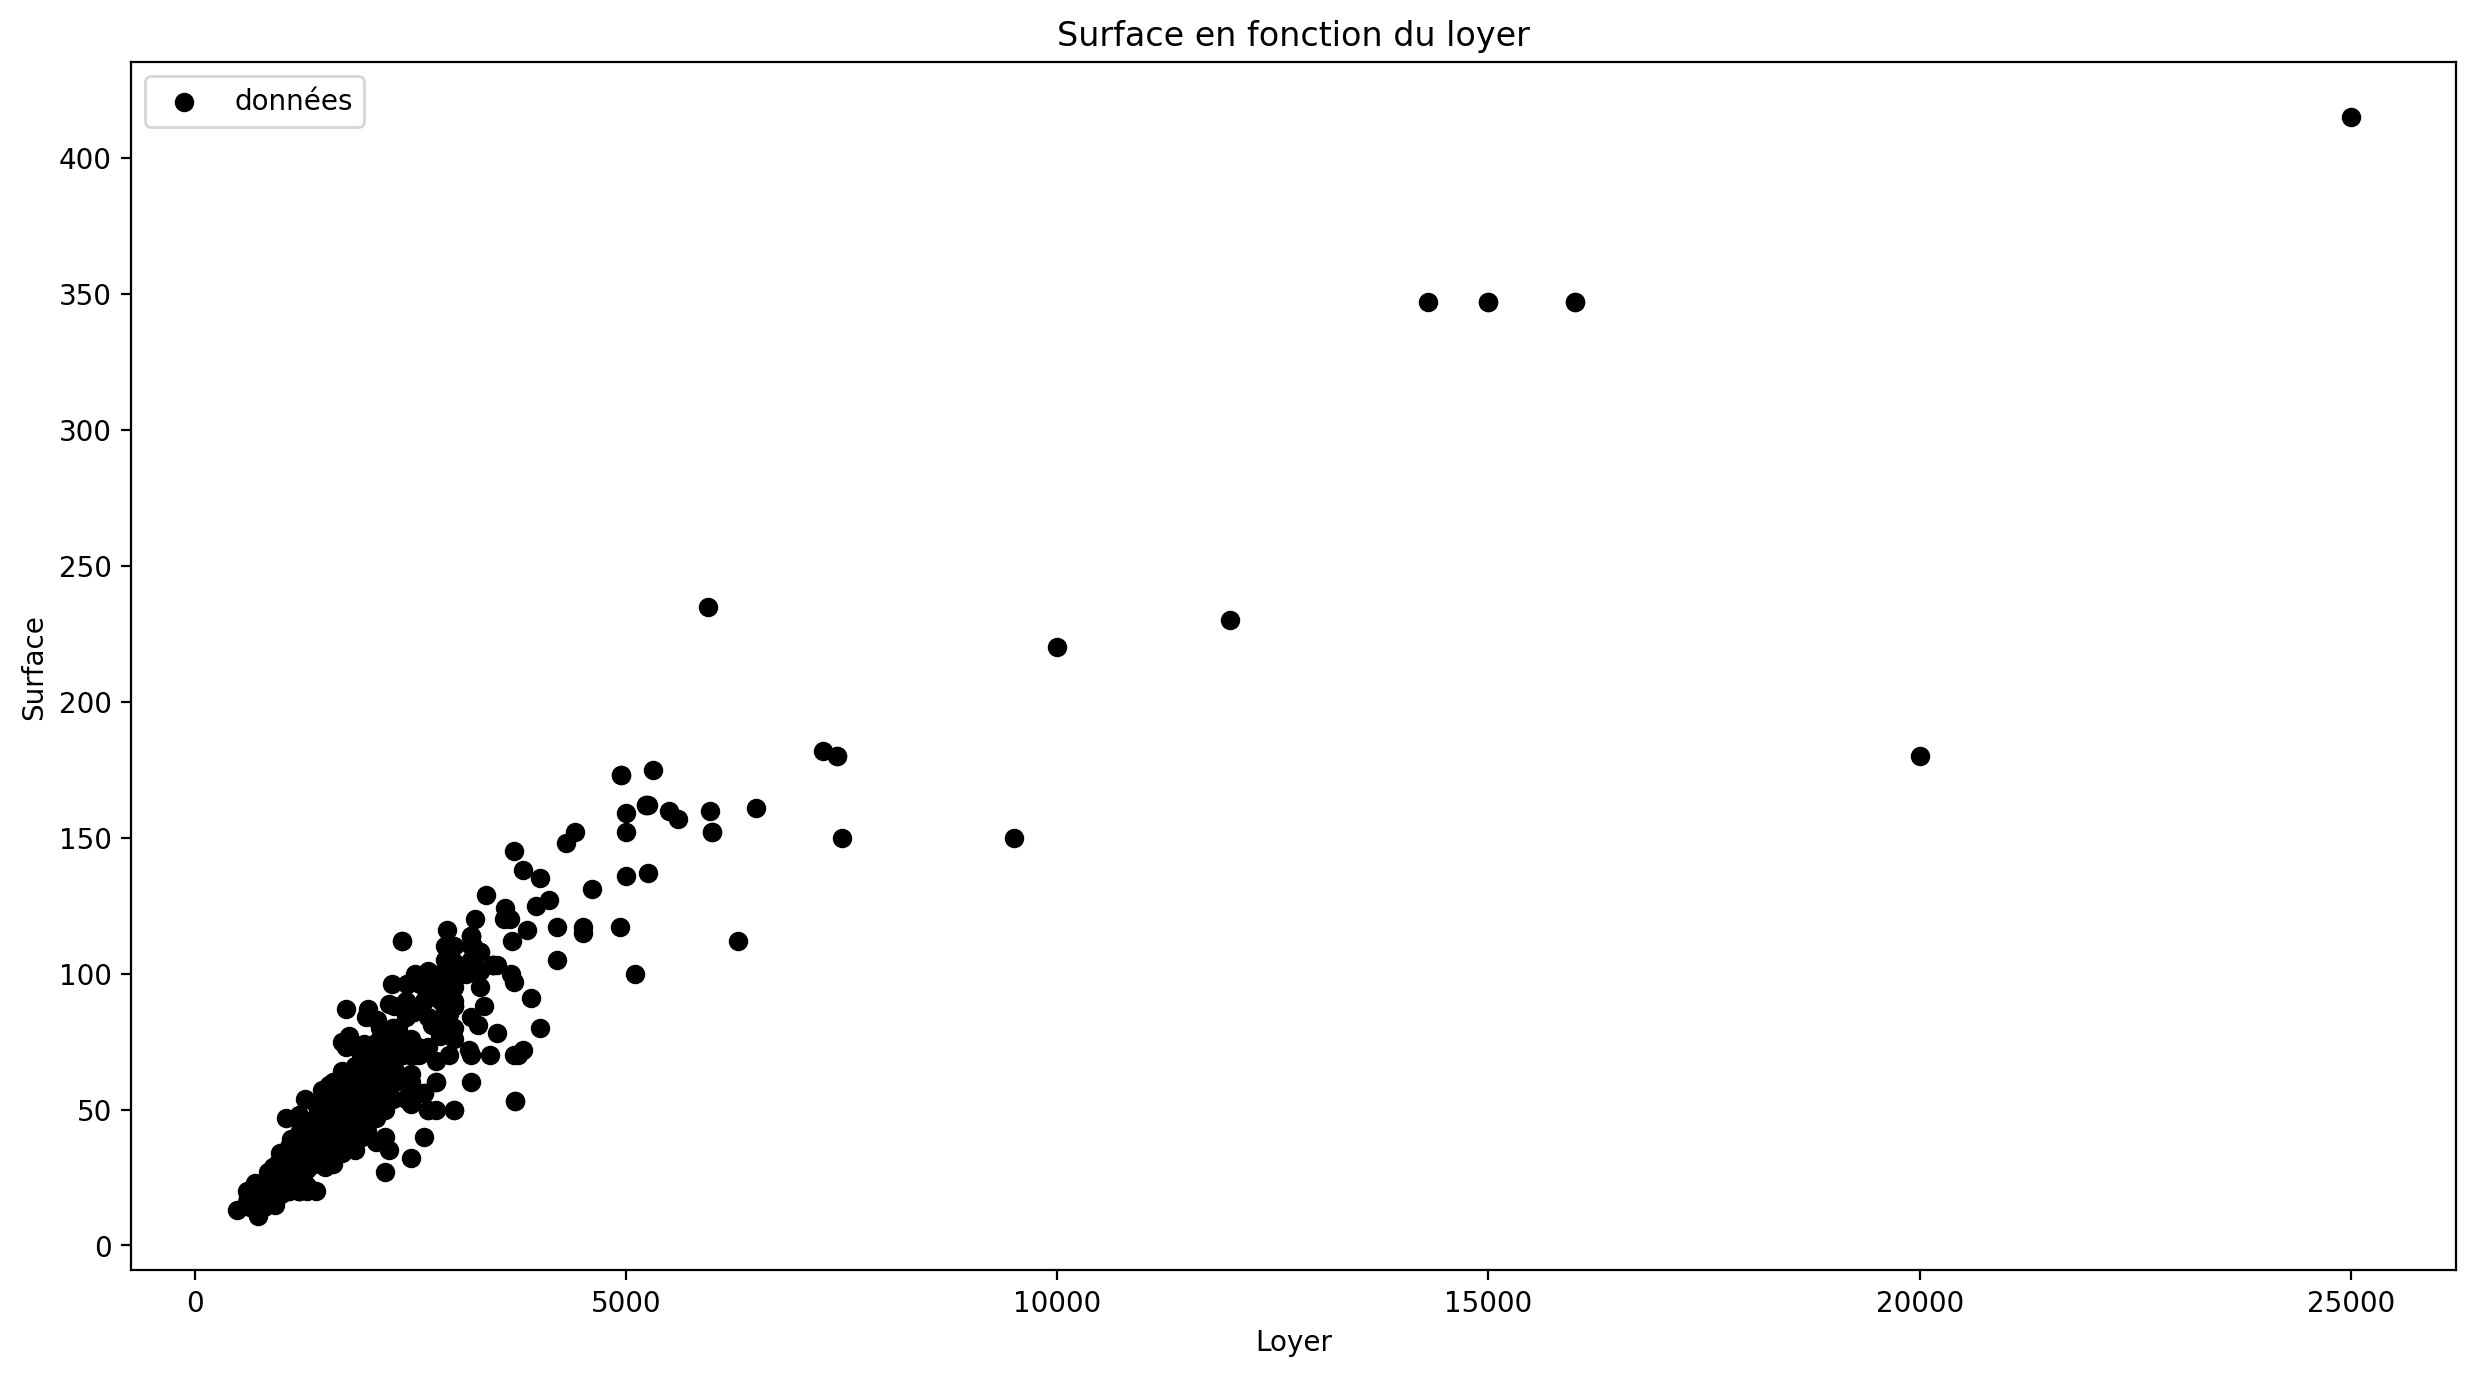

In [34]:
# - Quel est le format de nos données ?
# - Est-ce qu'il y a des valeurs aberrantes ?
# - Quelles sont les valeurs mix/max ?

# - Est-ce qu'il y a des valeurs aberrantes ?
ecart_type = logements_df["loyer"].std()
display(f"Ecart type de notre colonne loyer : {ecart_type}")
# > 2201.364353113282 - Est assez élevé, ça pourra nous jouer des tours

# L'ordre des lignes est très important, la taille du graphique doit être définie en premier
# Plus la valeur de dpi est grande, 
# plus il sera possible de zoomer dans le graphique (double-click)

plt.figure(figsize=(15, 8), dpi=200) 
plt.title('Surface en fonction du loyer')
plt.scatter(
    x = logements_df["loyer"], 
    y = logements_df["surface"], 
    color='black', 
    label="données"
)
plt.xlabel("Loyer")
plt.ylabel("Surface")
plt.legend()

# Phase 3 : Nettoyage / formattage des données

Notre jeu de données possède des données beaucoup aberrantes, nous allons donc y remédier pour retirer les valeurs aberrantes nous allons supprimer toutes les valeurs pour toutes les features (ici juste le loyer) dont la valeur est 1.5x inférieure au premier quartile (Q1) ou 1.5x supérieure au troisième quartile (Q3).
$$ ValeurAberranteBasse = Q1 - 1.5 * IQR $$
$$ ValeurAberranteHaute = Q1 + 1.5 * IQR $$
IQR ? Ceci signifie InterQuartile Range, c'est la soustration entre Q3 et Q1.
$$ IQR = Q3 - Q1 $$

Heureusement pour nous, pandas peut faire ces calculs pour nous.

- [Plus d'informations sur l'IQR (Écart interquartile)](https://fr.wikipedia.org/wiki/%C3%89cart_interquartile)

1099.0

501

501

Text(0, 0.5, 'Surface')

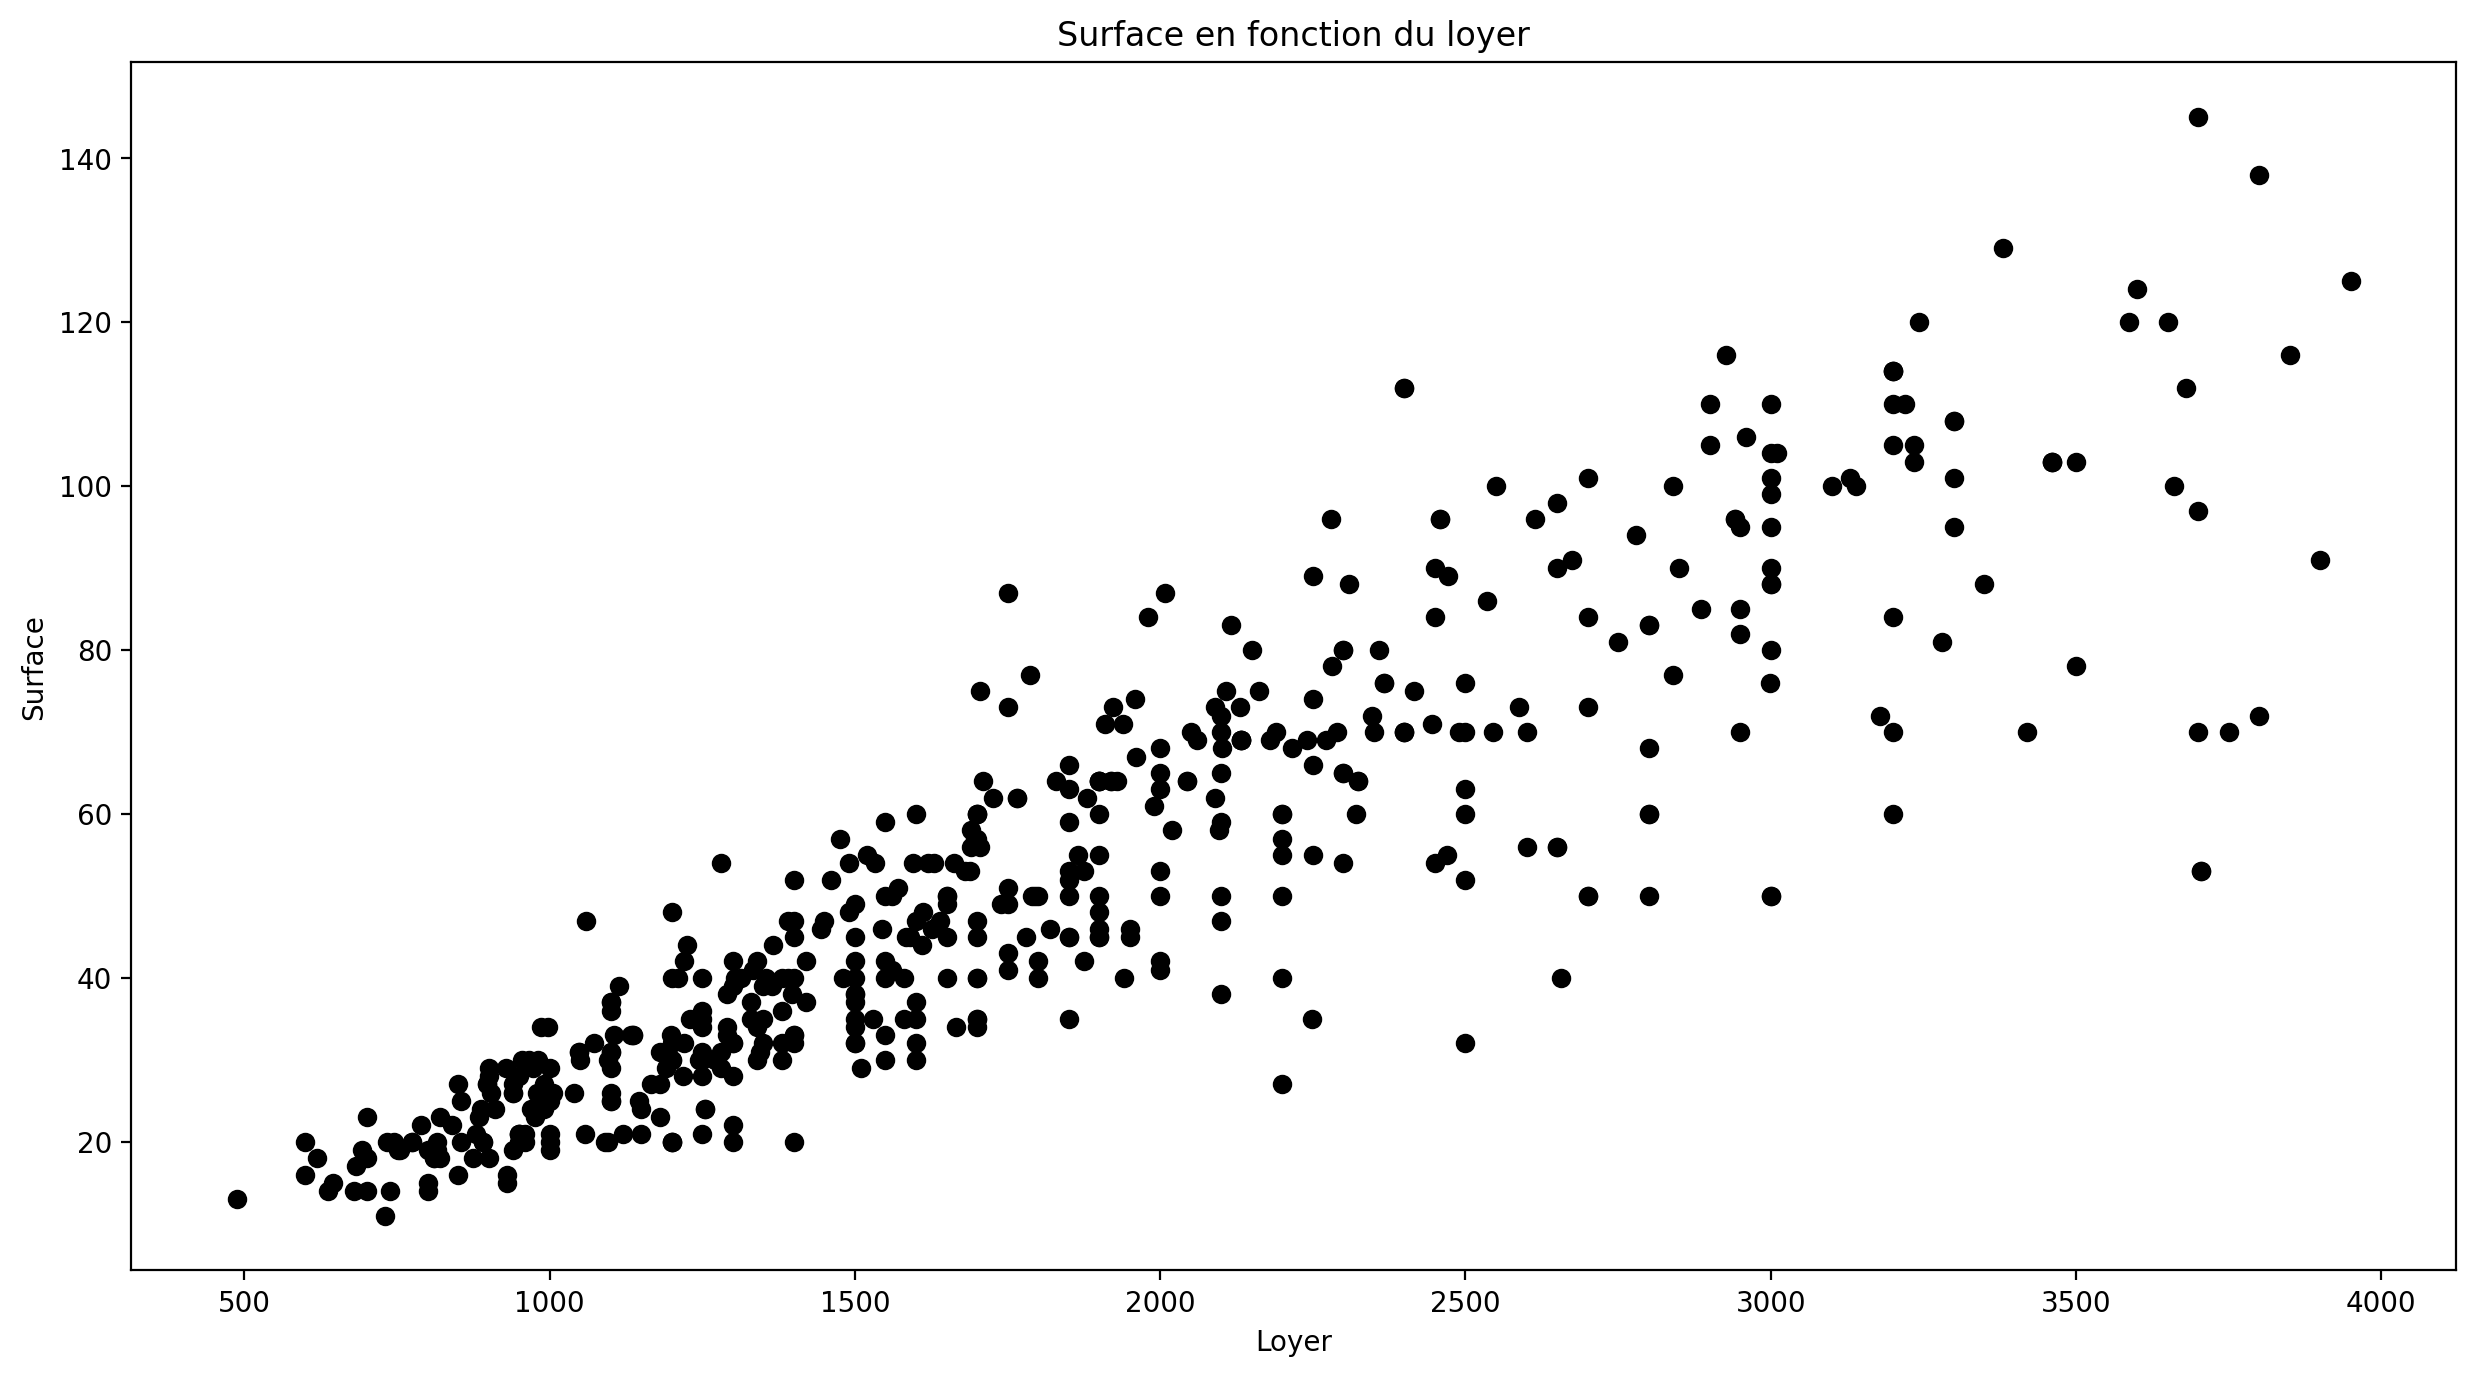

In [47]:
# pandas propose une méthode pour calculer les quartiles
Q1 = logements_df['loyer'].quantile(0.25) # Premier quartile
Q3 = logements_df['loyer'].quantile(0.75) # Troisième quartile
IQR = Q3 - Q1 # On calcule IQR
display(IQR)
# Nouvelle méthode "query", elle nous permet de filtrer les éléments de façon plus naturelle
logements_df.query('(@Q1 - 1.5 * @IQR) <= loyer <= (@Q3 + 1.5 * @IQR)', inplace=True)
display(logements_df["loyer"].std())
# Normalement notre écartype devrait être beaucoup plus petit, donc nos valeurs sont beaucoup moins disparates
# Nos calculs seront beaucoup moins soumis aux erreurs, notre apprentissage sera moins prompt aux erreurs

# La ligne précédente aurait pu être écrite de la façon suivante
# logements_df[(logements_df['loyer'] >= (Q1 - 1.5 * IQR)) & (logements_df['loyer'] <= (Q3 + 1.5 * IQR))]
# display(logements_df["loyer"].std())

# Avant de continuer, nous allons revoir notre graphique

plt.figure(figsize=(15, 8), dpi=200) 
plt.title('Surface en fonction du loyer')
plt.scatter(x = logements_df["loyer"], y = logements_df["surface"], color='black', label="données")
plt.xlabel("Loyer")
plt.ylabel("Surface")

Que constatez-vous ?

# Phase 4 : Modélisation

Nous allons utiliser scikit-learn et la régression linéaire via la ligne de code suivante `from sklearn.linear_model import LinearRegression`.

In [180]:
from sklearn.linear_model import LinearRegression

liste_entrees = logements_df[["surface"]]
sortie = logements_df['loyer']

# On commence par instancier notre regression linéaire
reg_lineaire = LinearRegression()

# Et on entraine notre modèle avec la méthode fit
reg_lineaire.fit(liste_entrees, sortie)

# Et enfin, on fait notre test. 
# Etant donnée que nous n'avons pas de jeux de test, nous allons en créer un grâce à numpy
donnees_surface_test = np.array([0, 60, 45, 25, 150, 90, 37]).reshape(-1, 1)

loyer_pred = reg_lineaire.predict(donnees_surface_test)

# On stocke le score de notre modèle pour comparer sa performance face à un autre modèle
score_reg_lineaire = round(reg_lineaire.score(liste_entrees, sortie) * 100, 2)
display(f"Score de notre modèle: {score_reg_lineaire}%")

# Enfin on retourne un dataframe pour que ça soit plus lisible
df = pd.DataFrame({'Surface (test)': donnees_surface_test.flatten(), 'Loyer (prediction)': loyer_pred})
df.sort_values(by=['Surface (test)'], inplace=True)
display(df)

'Score de notre modèle: 78.19%'

,Surface (test),Loyer (prediction)
0,0,486.899291
3,25,1127.378829
6,37,1434.809007
2,45,1639.762459
1,60,2024.050181
5,90,2792.625627
4,150,4329.776517


Nous avons donc prédit la valeur de notre loyer en fonction de la surface. **Ce sont des prédictions** rien ne nous dit que ça sera la même chose en vrai, l'idée est d'avoir un ordre d'idée.

Avant de finir, on va quand même tracer notre droite et afficher notre équation, c'est ce que nous cherchions à faire.

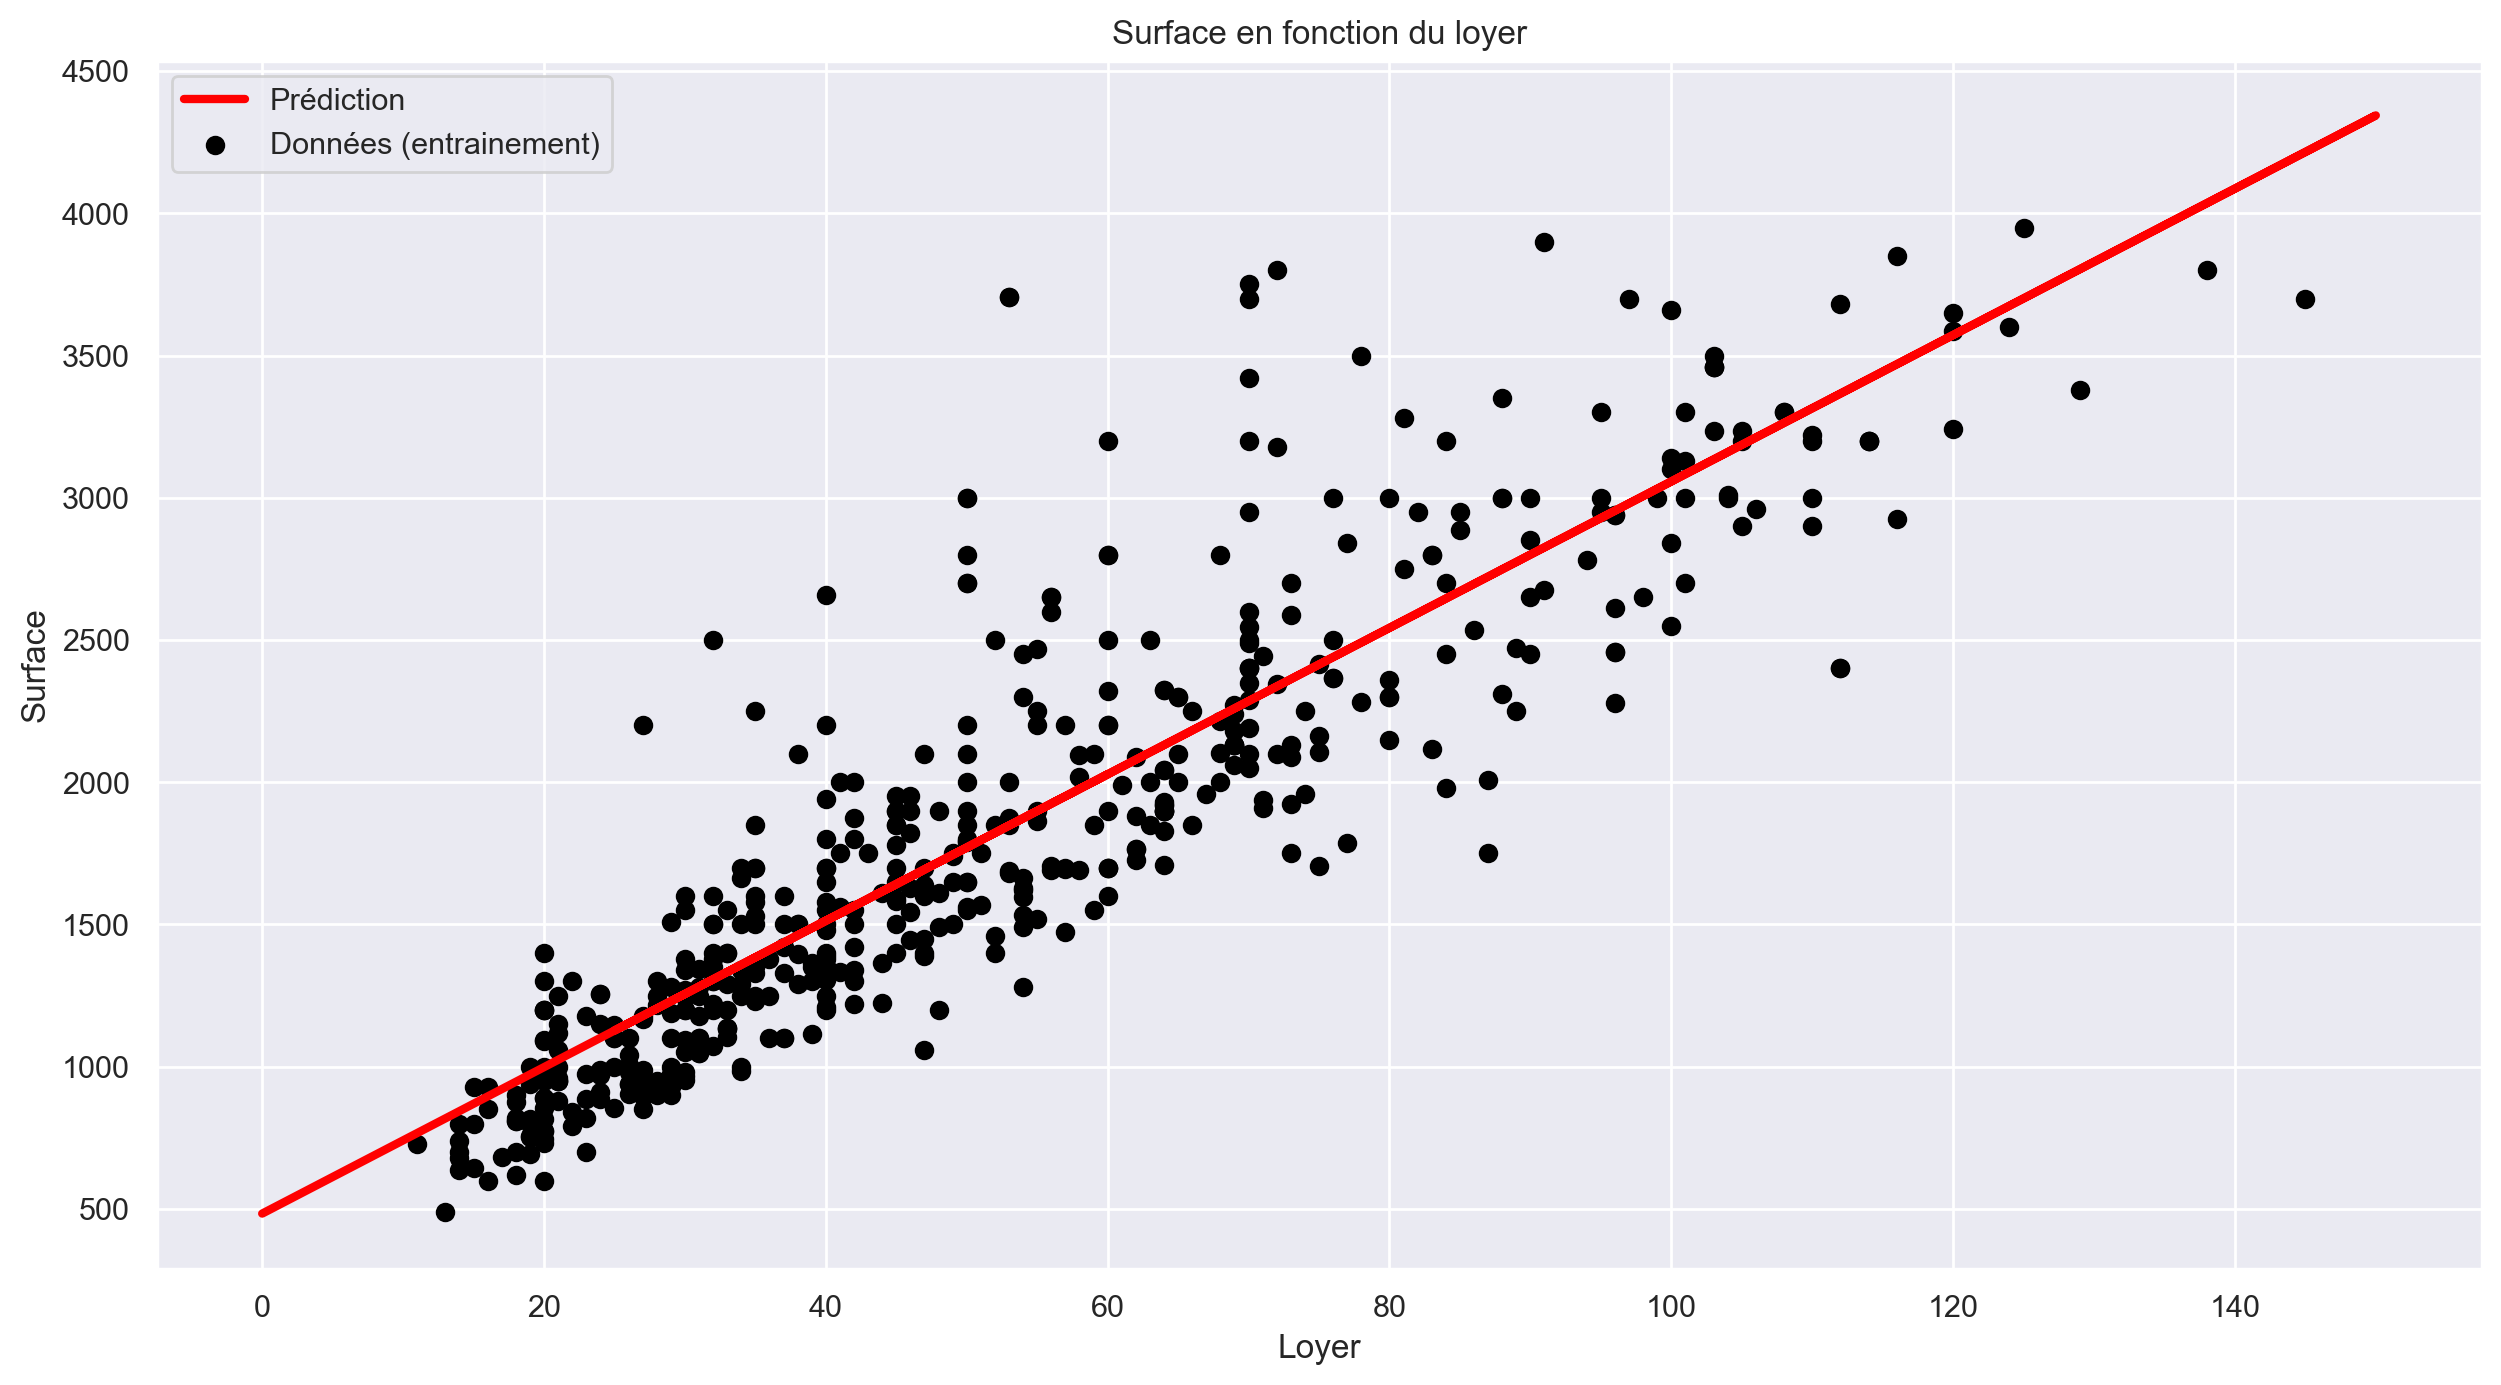

In [163]:
plt.figure(figsize=(15, 8), dpi=200) 
plt.title('Surface en fonction du loyer')
plt.scatter(x = logements_df["surface"], y = logements_df["loyer"], color='black', label="Données (entrainement)")
plt.plot(donnees_surface_test, loyer_pred.reshape(-1, 1), color='red', linewidth=3, label="Prédiction")
plt.xlabel("Loyer")
plt.ylabel("Surface")
plt.legend()

Voilà nous avons notre graphique. On remarquera que notre graphique possède désormais une courbe, cette dernière est censée passer au milieu de tous les points et donc être la plus représentative de notre jeu de données. Pour obtenir l'équation de la courbe ($ y = ax + b $ où y est le loyer et x la surface), il faut utiliser les propriétés "coef_" et "intercept_" de la classe "LinearRegression" après avoir appelé la fonction "fit()".

In [158]:
display(f"Le coefficient directeur est {reg_lineaire.coef_[0]}") # a de ax + b
display(f"L'ordonnée à l'origine est {reg_lineaire.intercept_}") # b de ax +b 

'Le coefficient directeur est 25.736019860465877'

"L'ordonnée à l'origine est 483.7077158452598"

Notre équation est donc 
$$ Loyer = 25.736019860465877 * Surface + 483.7077158452598 $$

On remarquera que la propriété "coef_" retourne un tableau. Pourquoi ? Tout simplement parce que la classe LinearRegression peut également être utilisée pour une régression linéaire multiple (avec plusieurs variables d'entrées). Notre regression linéaire étant simple, il n'y a qu'un seul coefficient directeur.

Pour terminer, on va refaire cet exercice mais avec HuberRegressor pour voir les différences, car oui, le travail de data-scientifique c'est aussi la comparaison de modèles, ce n'est pas uniquement trouver les meilleurs valeurs pour nos hyperparamètres.

'Score de notre modèle: 77.74%'

'Le coefficient directeur est 25.71978586428212'

"L'ordonnée à l'origine est 429.0031850383874"

,Surface (test),Loyer (prediction huber),Loyer (prediction linéaire)
0,0,429.003185,483.707716
3,25,1071.997832,1127.108212
6,37,1380.635262,1435.940451
2,45,1586.393549,1641.828610
1,60,1972.190337,2027.868907
5,90,2743.783913,2799.949503
4,150,4286.971065,4344.110695


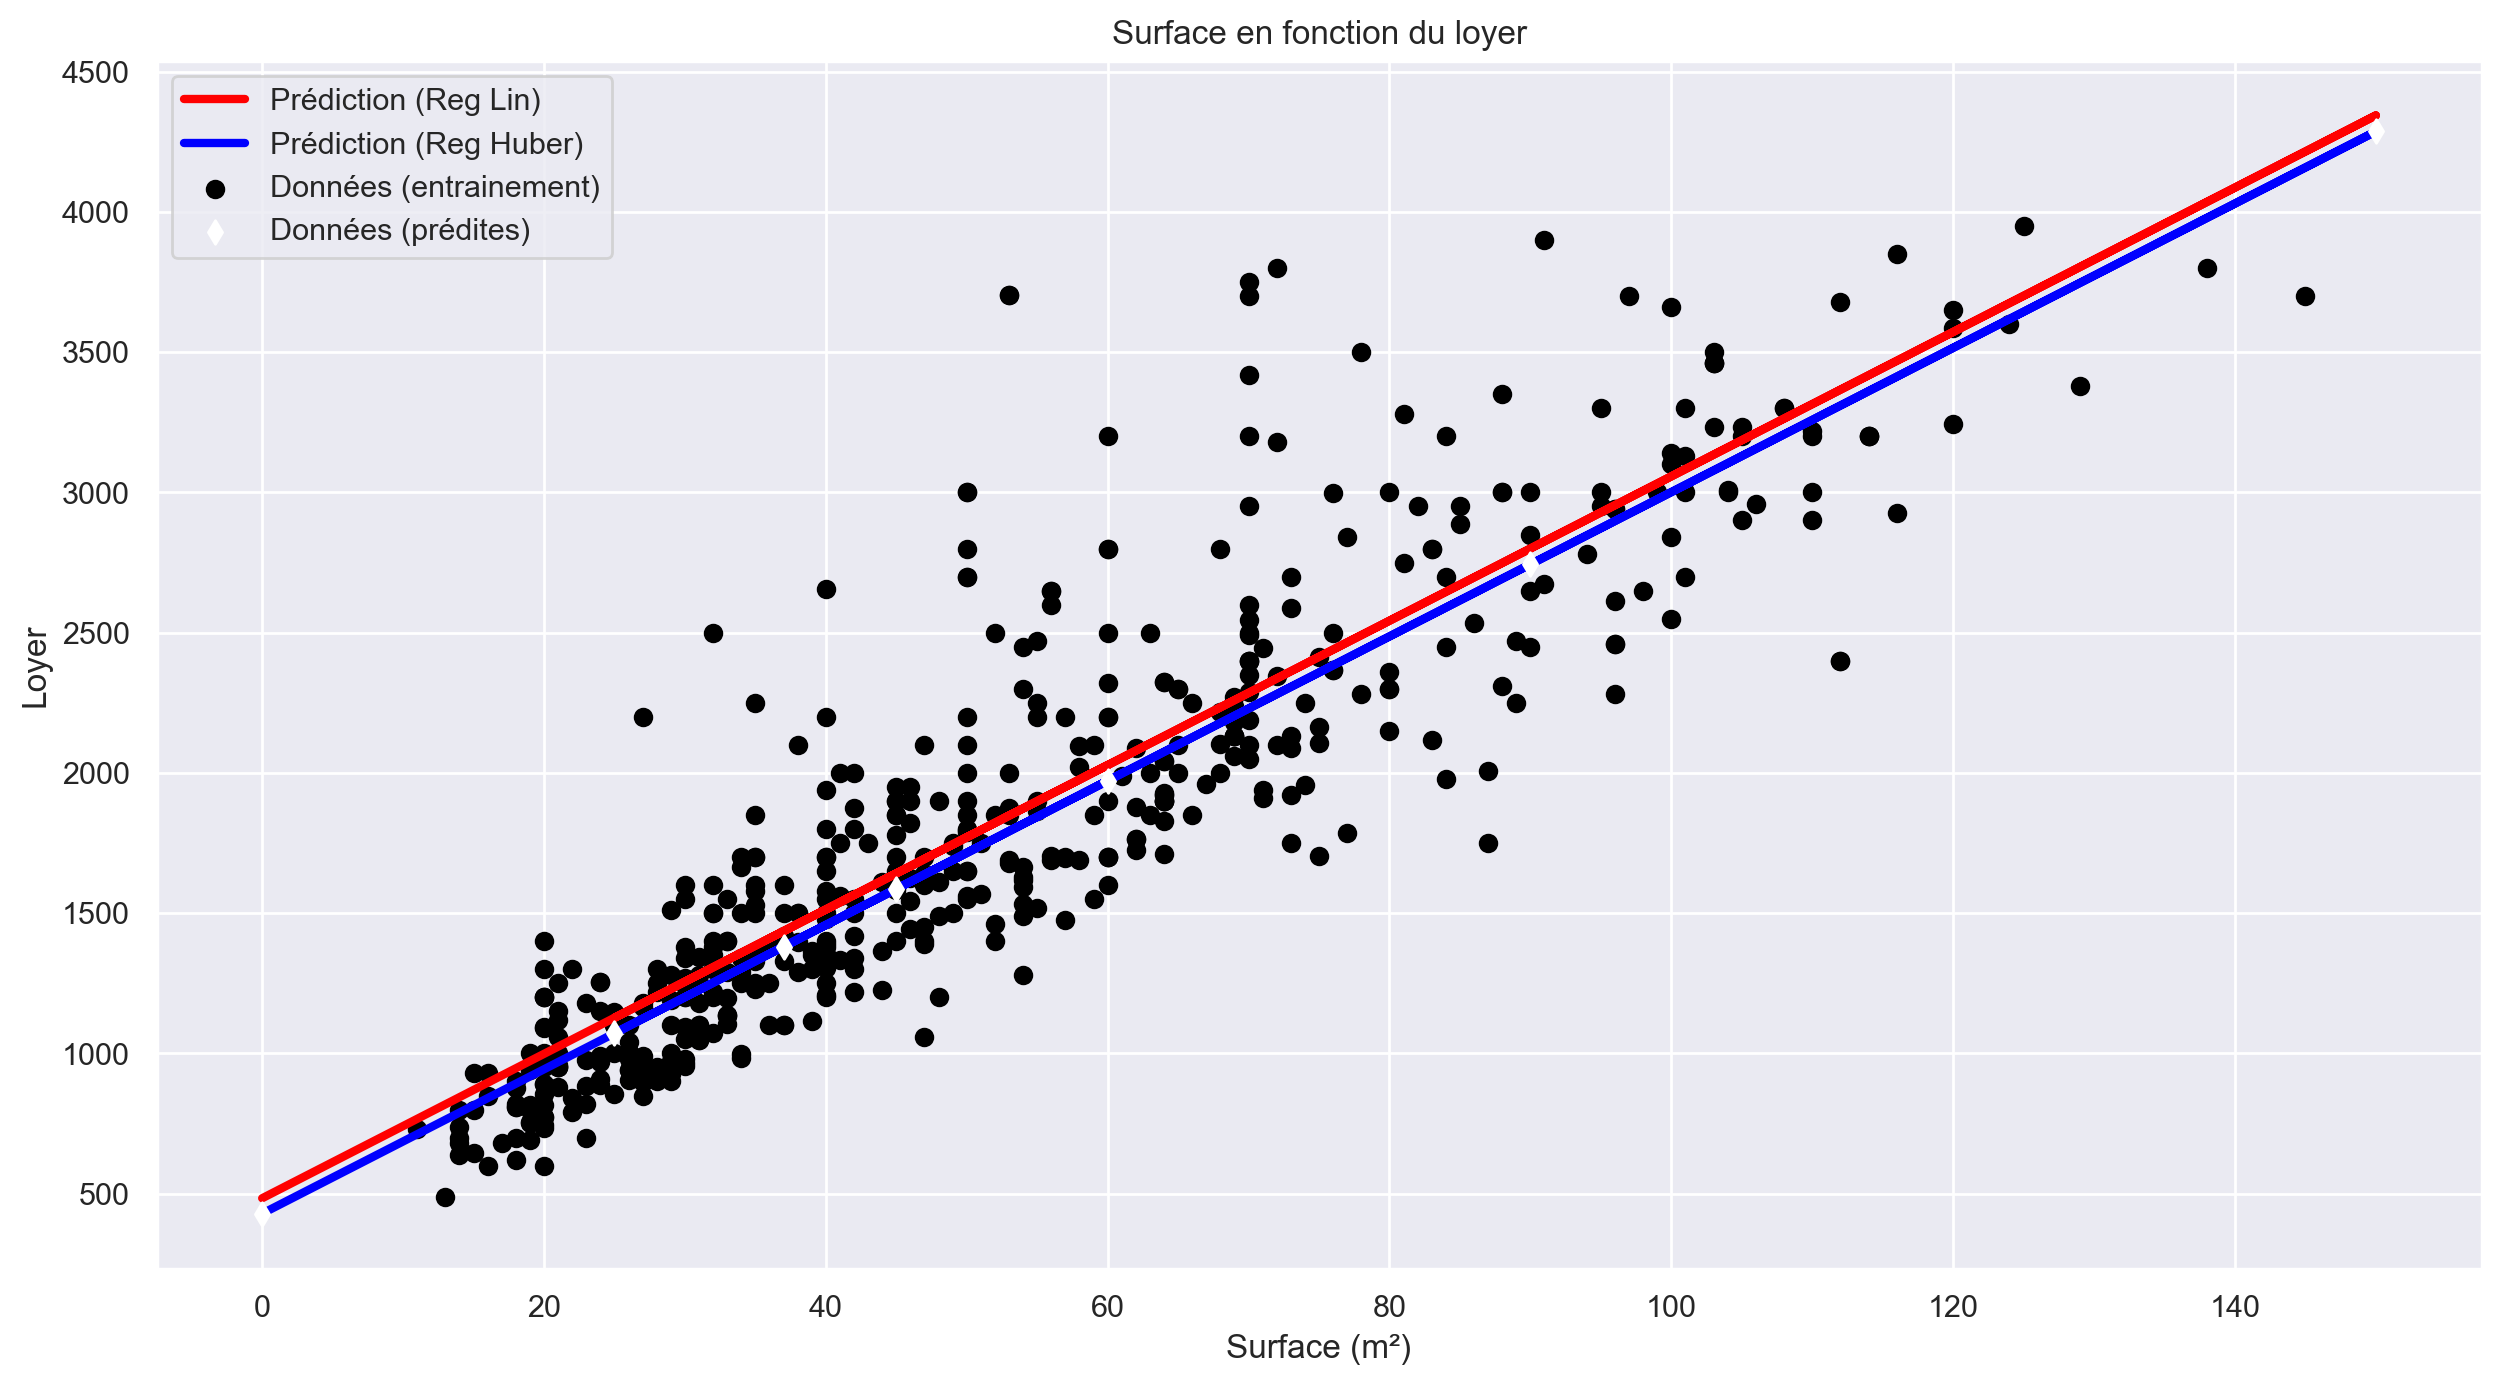

In [176]:
from sklearn.linear_model import HuberRegressor

liste_entrees = logements_df[["surface"]]
sortie = logements_df['loyer']

# On commence par instancier notre regression huber
reg_huber = HuberRegressor()

#Le reste ne change pas, on entraîne notre modèle
reg_huber.fit(liste_entrees, sortie)

# Et enfin, on fait notre test. 
# Etant donnée que nous n'avons pas de jeux de test, nous allons en créer un grâce à numpy
donnees_surface_test = np.array([0, 60, 45, 25, 150, 90, 37]).reshape(-1, 1)

loyer_pred_huber = reg_huber.predict(donnees_surface_test)

# On stocke le score de notre modèle pour comparer sa performance face à un autre modèle
score_reg_huber = round(reg_huber.score(liste_entrees, sortie) * 100, 2)
display(f"Score de notre modèle: {score_reg_huber}%")

display(f"Le coefficient directeur est {reg_huber.coef_[0]}") # a de ax + b
display(f"L'ordonnée à l'origine est {reg_huber.intercept_}") # b de ax + b 

# On retourne un dataframe avec les données de la régre
df = pd.DataFrame({
    'Surface (test)': donnees_surface_test.flatten(), 
    'Loyer (prediction huber)': loyer_pred_huber, 
    'Loyer (prediction linéaire)': loyer_pred
})
df.sort_values(by=['Surface (test)'], inplace=True)
display(df)

# On affiche notre graphique
plt.figure(figsize=(15, 8), dpi=200) 
plt.title('Surface en fonction du loyer')
plt.scatter(x = logements_df["surface"], y = logements_df["loyer"], color='black', label="Données (entrainement)")
plt.scatter(
    x = donnees_surface_test, 
    y = loyer_pred_huber, 
    color="white", 
    label="Données (prédites)", 
    zorder=5, 
    marker="d"
)

plt.plot(donnees_surface_test, loyer_pred, color='red', linewidth=3, label="Prédiction (Reg Lin)")
plt.plot(donnees_surface_test, loyer_pred_huber, color='blue', linewidth=3, label="Prédiction (Reg Huber)")

plt.ylabel("Loyer")
plt.xlabel("Surface (m²)")
plt.legend()

Que constatons-nous ?

Nous aurions pu également utiliser la validation croisée pour mieux valider notre modèle via la fonction `train_test_split`, à vous de voir si vous souhaitez le faire.

Notez que la classe HuberRegressor possède une propriété `outliers_`, elle permet de faire remonter les valeurs aberrantes sous forme d'un masque. Même si nous l'avons fait précédemment, il peut être intéressant de vérifier tout ça avec la propriété

Essayons !

In [171]:
# On récupére les valeurs de la propriété

liste_valeurs_aberrantes = reg_huber.outliers_
display(liste_valeurs_aberrantes[:20:])

array([False, False, False,  True,  True, False, False, False, False,
        True,  True, False, False, False, False, False, False, False,
       False, False])

```python
array([False, False, False,  True,  True, False, False, False, False,
        True,  True, False, False, False, False, False, False, False,
       False, False])
```
Vous devez avoir le résultat ci-dessus en sortie (sortie limitée aux vingt premières entrées). Notre tableau est donc un masque booléen, ceci signifie donc que notre Regression Huberienne a signalé les valeurs aberrantes ou non via la valeur True (valeur aberrante) et la valeur False (valeur non-aberrante).

Première étape : Explorer notre tableau.

- Combien il y a de valeurs aberrantes ?
- Quel est le ratio de valeurs aberrantes ?

### A vous de coder 
N'oubliez pas d'utiliser la fonction `display()` pour afficher les résultats.

In [179]:
# - Combien il y a de valeurs aberrantes ?

# - Quel est le ratio de valeurs aberrantes / valeurs non-aberrantes ?
# Ici nous sommes dans une cas de filtre pour rappel, pour filtre un tableau, il nous faut appliquer la syntaxe suivante
# tableau[tableau <ma condition>]
# Et c'est la fonction len() qui nous retourne le nombre d'éléments d'un liste/dataframe

Une fois cela fait nous allons filtrer notre dataframe d'entrainement grâce à notre masque.

In [182]:
# On filtre notre df des données aberrantes trouvées par HuberRegressor
logements_sans_ab_df = logements_df[liste_valeurs_aberrantes]

# Et ensuite on refait tout comme avant.

liste_entrees_sans_ab = logements_sans_val_ab_df[["surface"]]
sortie_sans_ab = logements_sans_val_ab_df['loyer']

reg_huber_sab = HuberRegressor()

# On entraîne notre modèle
reg_huber_sab.fit(liste_entrees_sans_ab, sortie_sans_ab)

display(f"Le coefficient directeur est {reg_huber_sab.coef_[0]}") # a de ax + b
display(f"L'ordonnée à l'origine est {reg_huber_sab.intercept_}") # b de ax +b 

# On stocke le score de notre modèle pour comparer sa performance face à un autre modèle
score_reg_huber_sab = round(reg_huber_sab.score(liste_entrees_sans_ab, sortie_sans_ab) * 100, 2)
display(f"Score de notre modèle: {score_reg_huber_sab}%")

donnees_surface_test = np.array([0, 60, 45, 25, 150, 90, 37]).reshape(-1, 1)

loyer_pred_huber_sans_ab = reg_huber.predict(donnees_surface_test)

# On retourne un dataframe
df = pd.DataFrame({
    'Surface (test)': donnees_surface_test.flatten(), 
    'Loyer (prediction reg huber)': loyer_pred_huber, 
    'Loyer (prediction reg huber sans valeurs aberrantes)': loyer_pred_huber_sans_ab,
    'Loyer (prediction linéaire)': loyer_pred
})
df.sort_values(by=['Surface (test)'], inplace=True)
display(df)

'Le coefficient directeur est 22.773088527053062'

"L'ordonnée à l'origine est 758.1984466147313"

'Score de notre modèle: 53.22%'

,Surface (test),Loyer (prediction reg huber),Loyer (prediction reg huber sans valeurs aberrantes),Loyer (prediction linéaire)
0,0,429.003185,429.003185,486.899291
3,25,1071.997832,1071.997832,1127.378829
6,37,1380.635262,1380.635262,1434.809007
2,45,1586.393549,1586.393549,1639.762459
1,60,1972.190337,1972.190337,2024.050181
5,90,2743.783913,2743.783913,2792.625627
4,150,4286.971065,4286.971065,4329.776517


Que constatez-vous ?

### A vous de coder

A partir ce que ce nous avons fait, complétez le graphique suivant :

- Rajoutez une nouvelle droite de regression avec une couleur différente. Cette droite doit être basée sur les valeurs non-aberrantes et donc le modèle que nous venons d'entraîner.
- Affichez dans une couleur différente les points dont les valeurs ne sont pas aberrantes (selon HuberRegressor)
- Affichez l'equation de chacune des droites qui ont été dessinées depuis de le début sur le graphique (fonction plt.figtext())

[Documentation de la fonction plt.figtext()](https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.figtext.html)

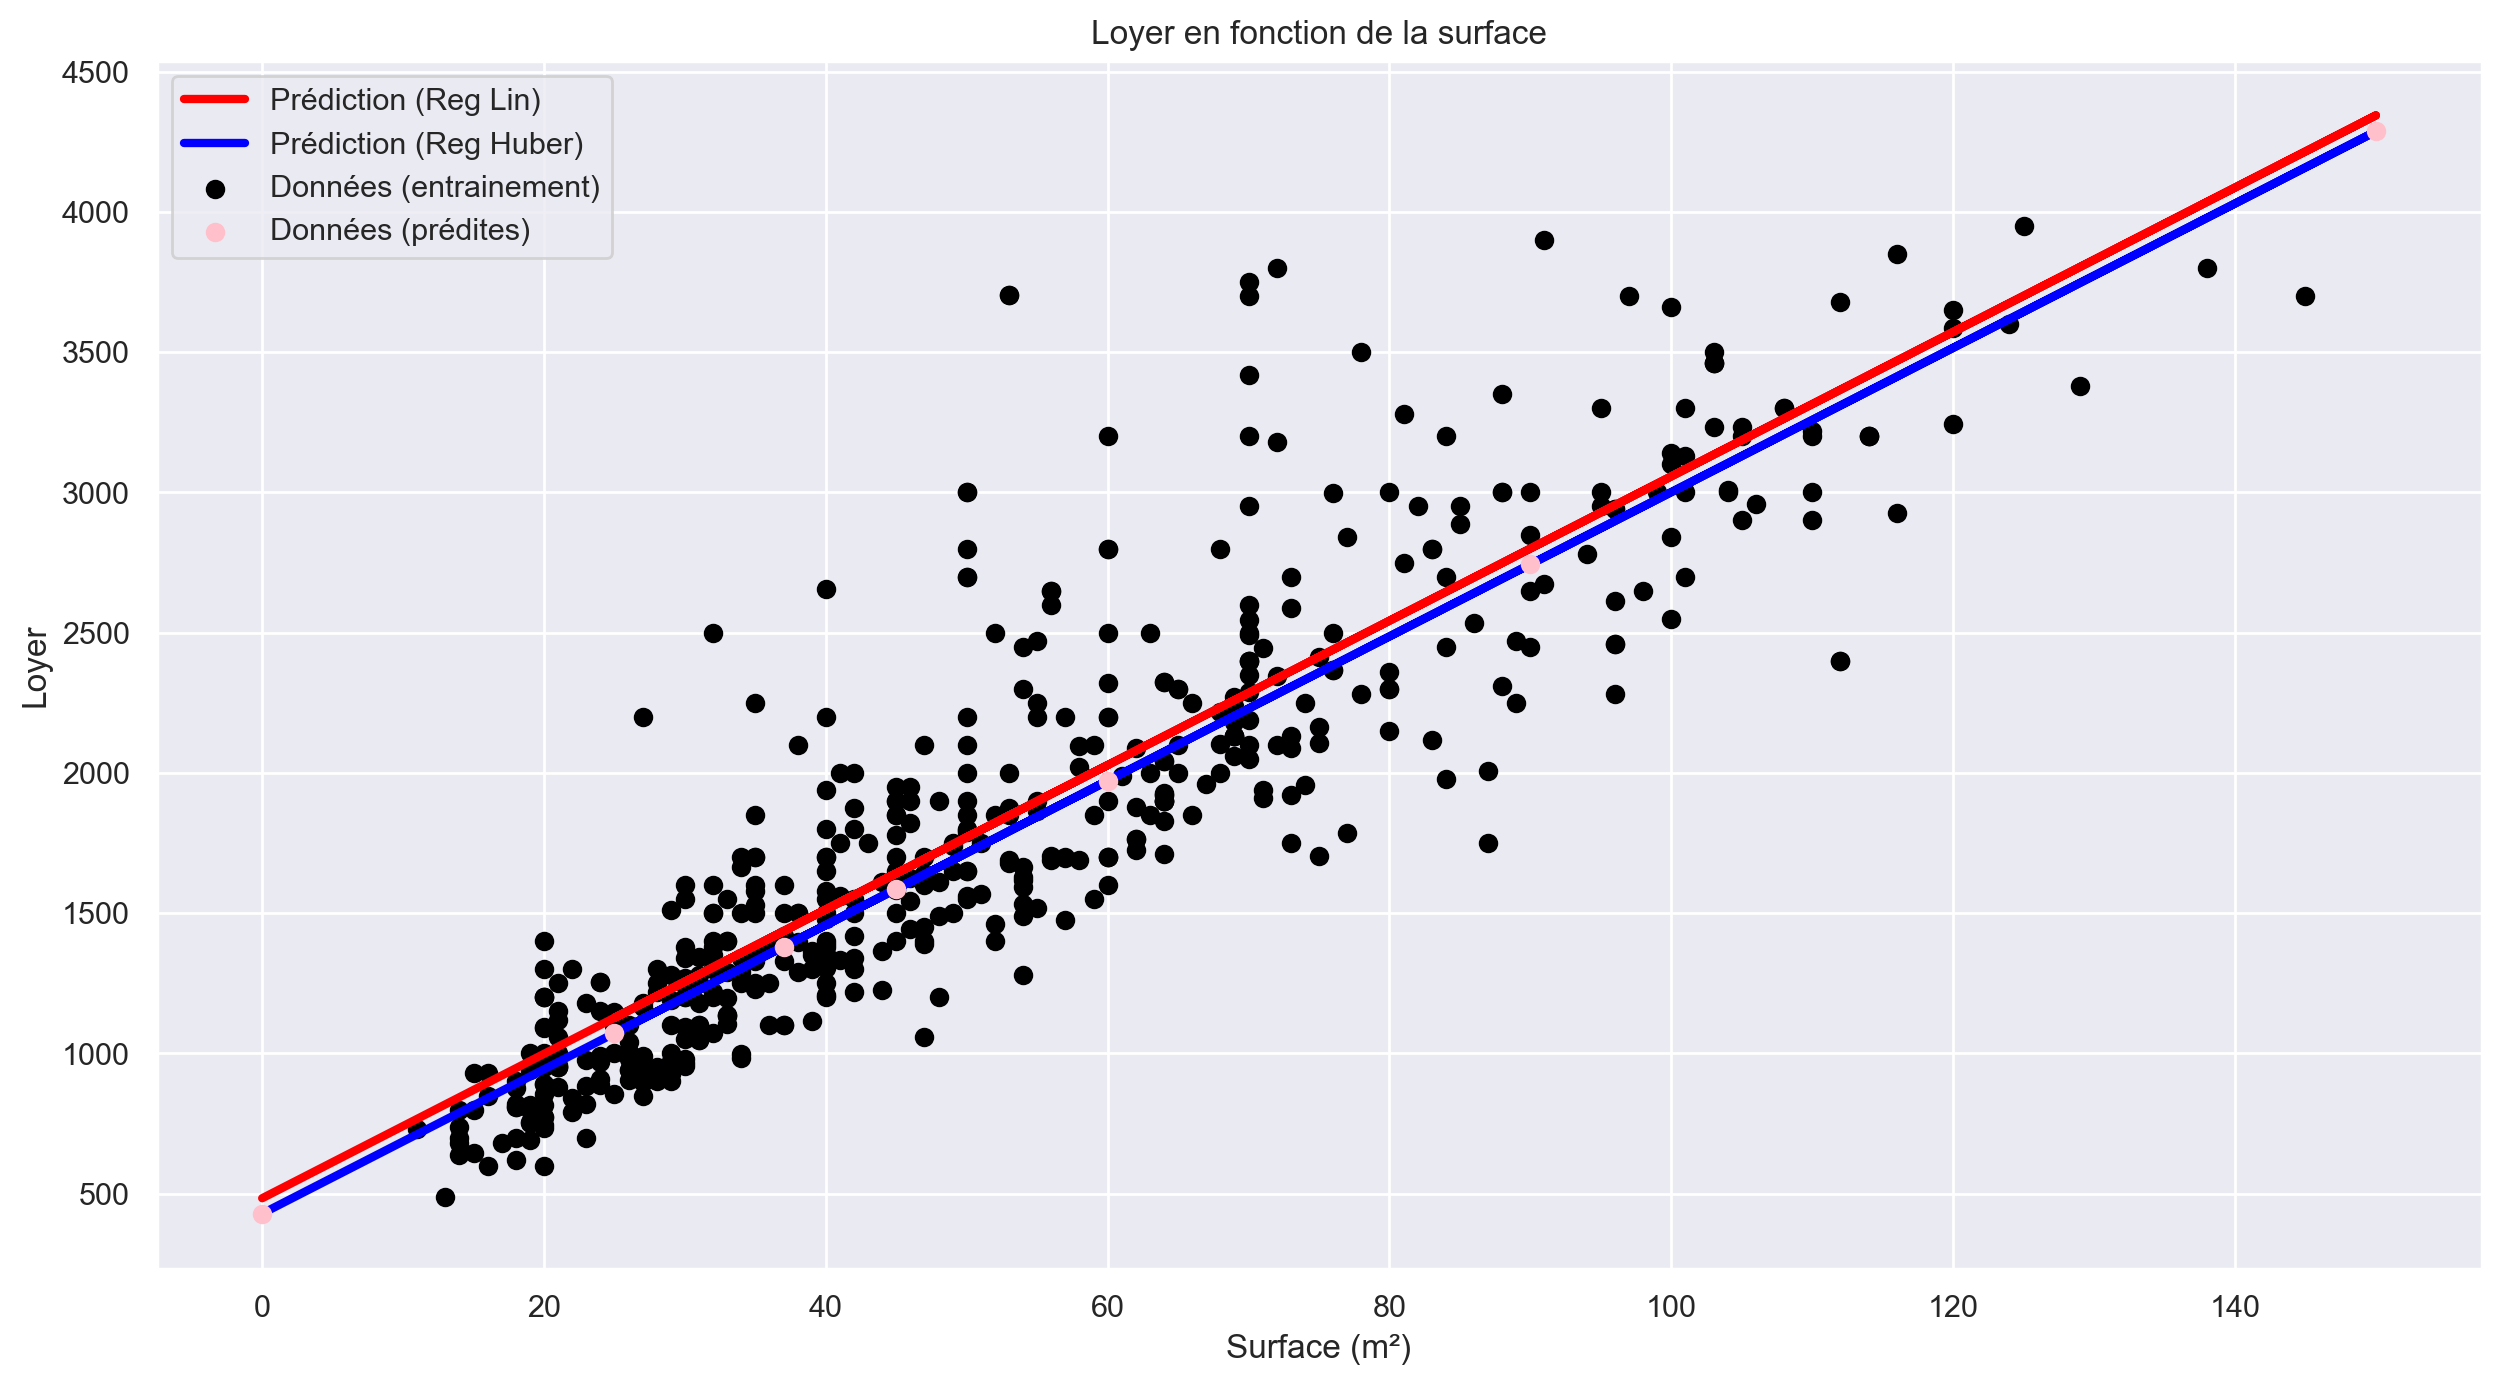

In [175]:
plt.figure(figsize=(15, 8), dpi=200) 
plt.title('Surface en fonction du loyer')
plt.scatter(x = logements_df["surface"], y = logements_df["loyer"], color='black', label="Données (entrainement)")
plt.scatter(x = donnees_surface_test, y = loyer_pred_huber, color="pink", label="Données (prédites)", zorder=5)

plt.plot(donnees_surface_test, loyer_pred, color='red', linewidth=3, label="Prédiction (Reg Lin)")
plt.plot(donnees_surface_test, loyer_pred_huber, color='blue', linewidth=3, label="Prédiction (Reg Huber)")

plt.ylabel("Loyer")
plt.xlabel("Surface (m²)")
plt.legend()

Voilà, nous avons vu dans les grandes lignes la regression linéaire simple, il y a bien évidemment d'autres modèles que nous pourrions utiliser. Mais travailler sur une régression linéaire simple est assez rare dans le monde "réel". C'est pourquoi dans la prochaine partie, nous allons voir la régression linéaire multiple. Beaucoup plus en phase avec le mode réel et donc notre réel besoin.

## Pour terminer

- Ecrire une fonction prenant en paramètre une surface et retourne le loyer avec les paramètres de la régression linéaire
- Ecrire une fonction prenant en paramètre une surface et retourne le loyer avec les paramètres de la regression huberienne

In [1]:
# Ecrire une fonction prenant en paramètre une surface et retourne le loyer avec les paramètres de la régression linéaire

# Ecrire une fonction prenant en paramètre une surface et retourne le loyer avec les paramètres de la regression huberienne

### Pour aller plus loin

- Optimisez le code, nous avons fait beaucoup de duplication au niveau de la variable `donnees_surface_test`, il n'y avait pas mieux à faire ?
- Il y a un dataset hubble.csv dans le dossier de la ressource, essayez de faire la même chose.